In [10]:
import pathlib
import matplotlib
import pandas as pd

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenSimpleFactory()
    g_energietraeger_factory = General.GEnergietraegerSimpleFactory()
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_klassen_factory, g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_pickle_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data_factory = Nutzenergieanalyse.NEADataETKlassenFactory(nea_data_pickle_factory)
    nea_data = nea_data_factory.create(g_data)
    return nea_data

def create_eb_data(g_data: Domain.General.GData):
    eb_laender_factory = Energiebilanz.EBLaenderDefaultFactory()
    eb_laender = eb_laender_factory.create(g_data.laender)
    eb_sektoren_factory = Energiebilanz.EBSektorenDefaultFactory(g_data.sektoren)
    eb_sektoren = eb_sektoren_factory.create()
    eb_data_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_energietraeger_factory = Energiebilanz.EBEnergietraegerDefaultFactory()
    eb_energietraeger = eb_energietraeger_factory.create(g_data)
    eb_data = eb_data_factory.create(eb_energietraeger, g_data)
    return eb_data

laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_dict_data = create_nea_data(general_data).data
nea_data = {land.name: {sektor.name: {bereich.name: nea_dict_data[land][sektor][bereich] for bereich in nea_dict_data[land][sektor].keys()} for sektor in nea_dict_data[land].keys()} for land in nea_dict_data.keys()}

#eb_dict_data = create_eb_data(general_data).data
#eb_data = {land.name: {sektor.name: eb_dict_data[land][sektor] for sektor in nea_dict_data[land].keys()} for land in eb_dict_data.keys()}



In [11]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

In [12]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)

In [13]:
def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()

def run_scenario(df: pd.DataFrame, wanted: pd.Series):
    et = wanted.name
    
    df_relative = calc_relative(df)
    df_relative_without_et = df_relative.drop(et, axis=1)
    df_relative_without_et_relative = calc_relative(df_relative_without_et)
    
    to_sub = df[et] - wanted
    to_add = (df_relative_without_et_relative.transpose() * to_sub).transpose()
    to_add[et] = to_sub * -1

    result = df + to_add
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered

In [14]:
def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()

def run_scenario(df: pd.DataFrame, wanted: pd.Series):
    et = wanted.name
    
    df_relative = calc_relative(df)
    df_relative_without_et = df_relative.drop(et, axis=1)
    df_relative_without_et_relative = calc_relative(df_relative_without_et)
    
    to_sub = df[et] - wanted
    to_add = (df_relative_without_et_relative.transpose() * to_sub).transpose()
    to_add[et] = to_sub * -1

    result = df + to_add
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered
    
def run_scenarios(df: pd.DataFrame, wanted: pd.DataFrame):
    global_result = df.copy()
    for et in wanted.columns:
        local_result = run_scenario(global_result, wanted[et])
        global_result = local_result.drop(et, axis=1)
    result = pd.concat([global_result, wanted], axis=1)
    result_reordered = result.reindex(columns=df.columns)
    return result_reordered
    

In [15]:
def create_linear_scenario(series: pd.Series, start: str, end: str, end_value):
    et = series.name
    index = series[start:end][1:].index
    start_value = series[start]
    decrement = start_value / (len(index))
    start_series = series[:start]
    wanted_series = pd.Series([start_value - decrement * (i + 1) for i in range(len(index))], index=index)
    end_series = series[end:][1:]
    result = pd.concat([start_series, wanted_series, end_series])
    result.name = series.name
    return result


In [16]:
#szenario
# wien 2040 -> 0 gas
# 2035 -> 0 oel
# 2030 -> 0 kohle
test_scenario_gas = create_linear_scenario(heizen_ph_wien_ex['Fossile gasförmig'], '2020', '2040', 0)

test_scenario_oel = create_linear_scenario(heizen_ph_wien_ex['Fossile flüssig'], '2020', '2035', 0)
test_scenario_oel = create_linear_scenario(test_scenario_oel, '2035', '2040', 0)

test_scenario_kohle = create_linear_scenario(heizen_ph_wien_ex['Fossile fest'], '2020', '2030', 0)
test_scenario_kohle = create_linear_scenario(test_scenario_kohle, '2030', '2040', 0)

test_scenario = pd.concat([test_scenario_gas, test_scenario_oel, test_scenario_kohle], axis=1)

<Axes: >

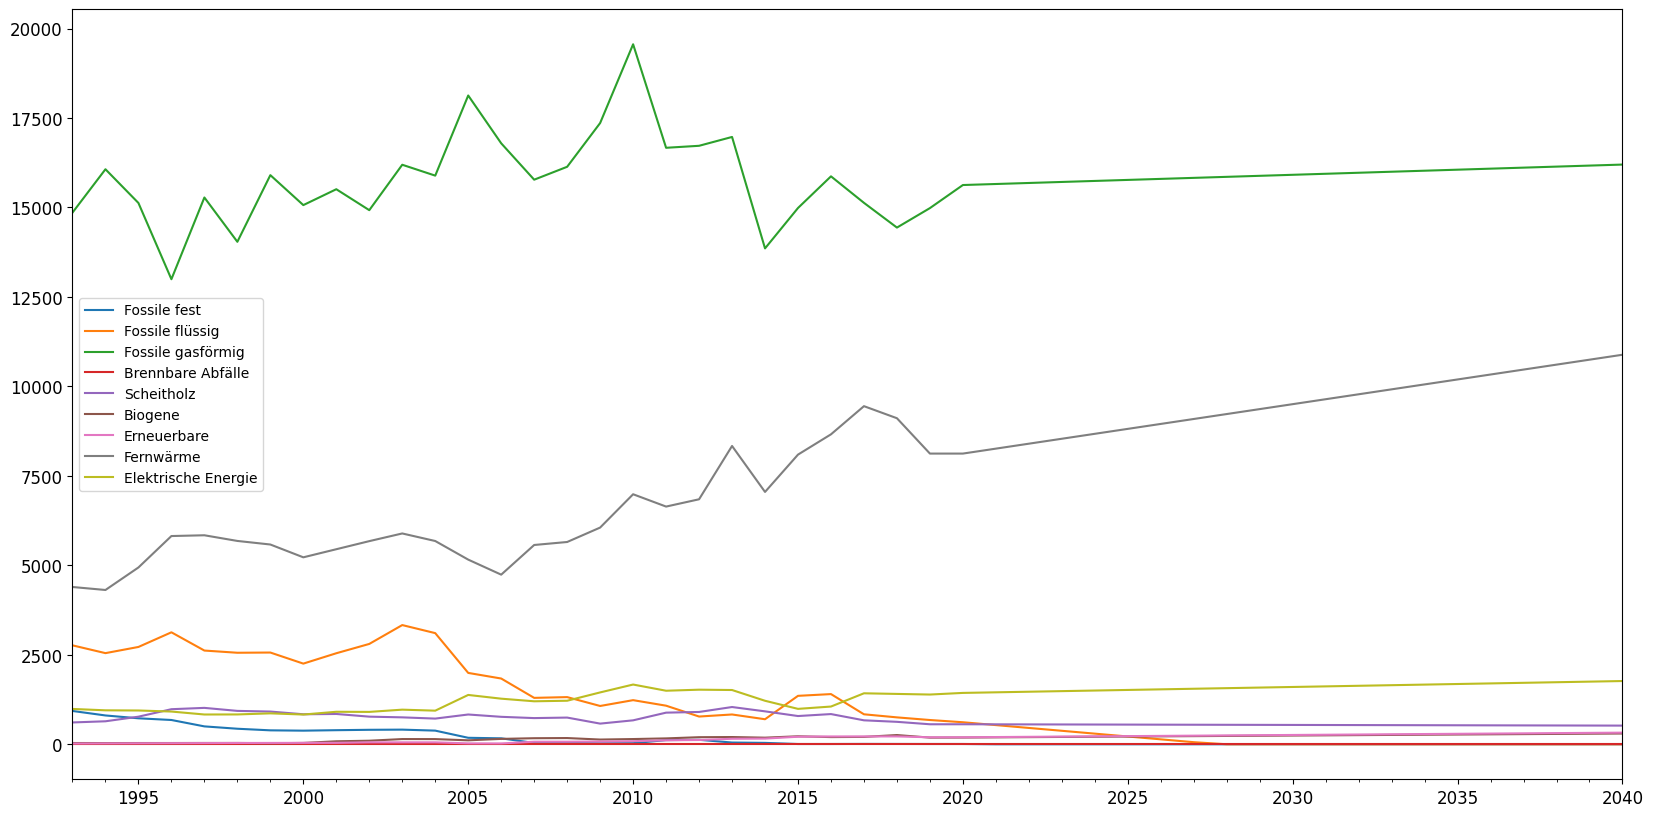

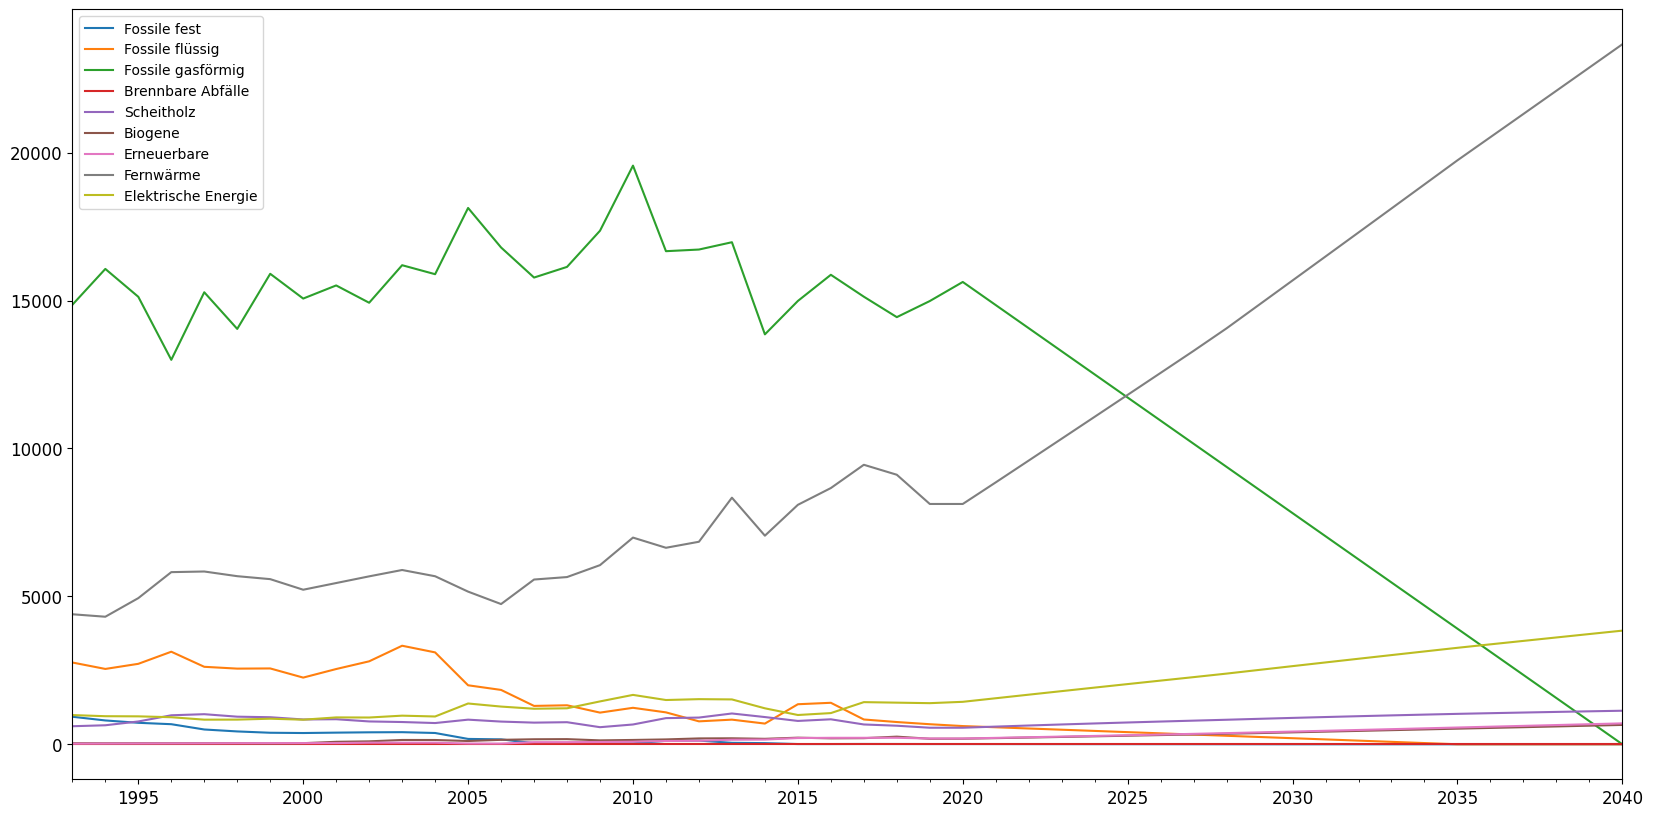

In [17]:
matplotlib.rcParams["figure.figsize"] = (20,10)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

heizen_ph_wien = nea_data['wien']['Wohngebäude']['Heizen']
heizen_ph_wien_ex = extrapolation_extension.run(heizen_ph_wien, pd.PeriodIndex(pd.period_range(start=heizen_ph_wien.index[0], end='2040', freq='A'), name=heizen_ph_wien.index.name))
heizen_ph_wien_ex = clean_negative_values(heizen_ph_wien_ex)

test_scenario_result = run_scenarios(heizen_ph_wien_ex, test_scenario)

heizen_ph_wien_ex.plot()
test_scenario_result.plot()

#(heizen_ph_wien_ex - test_scenario_result).sum(axis=1)
#test: (heizen_ph_wien_ex - test_scenario_2_result).sum(axis=1)
#fernwaerme, strom, umweltwaereme -> 1,2,3% steigung
#scheitholz bleibt gleich
#wie entwickeln sich die anderen?
#individuell pro bundesland
#gesamtergebnis fuer oesterreich
